# Vorlesung 3: Robuste Verteilungsdiagnostik: Histogramm, KDE,ECDF/QQ

In [4]:
# Code setup für VL3 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")

csv_path = "OECD.WISE.WDP,DSD_HSL@DF_HSL_CWB,+all.csv"
df = pd.read_csv(csv_path, low_memory=False)

unnamed_cols = [c for c in df.columns if "unnamed" in c.lower()]
if unnamed_cols:
    df = df.drop(columns=unnamed_cols)

df = df.rename(
    columns={
        "REF_AREA": "country",
        "MEASURE": "measure",
        "UNIT_MEASURE": "unit",
        "TIME_PERIOD": "year",
        "OBS_VALUE": "value",
    }
)

df["year"] = pd.to_numeric(df["year"], errors="coerce")
df["value"] = pd.to_numeric(df["value"], errors="coerce")
for cat_col in ("country", "measure", "unit"):
    if cat_col in df.columns:
        df[cat_col] = df[cat_col].astype("category")

df_country_mean = (
    df.groupby(["country", "year"])["value"]
      .mean()
      .reset_index()
      .dropna(subset=["year", "value"])
)

avg_wellbeing = (
    df_country_mean.groupby("country")["value"]
    .mean()
    .sort_values(ascending=False)
)

top_k = 8
bottom_k = 8
top_countries = avg_wellbeing.head(top_k).index.tolist()
bottom_countries = avg_wellbeing.tail(bottom_k).index.tolist()
focus_countries = top_countries[:4] + bottom_countries[:4]

country_code = "DEU"  # Land für detaillierte Analysen anpassen
s = (
    df_country_mean.loc[df_country_mean["country"] == country_code, "value"]
    .dropna()
    .sort_values()
)


/var/folders/dz/832hrd_95rn7bh82j0wx55ym0000gn/T/ipykernel_42594/3846353491.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["country", "year"])["value"]
/var/folders/dz/832hrd_95rn7bh82j0wx55ym0000gn/T/ipykernel_42594/3846353491.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_country_mean.groupby("country")["value"]


[DEU] Tukey-Ausreißer: 1  |  ModZ-Ausreißer: 2


TypeError: NDFrame.reindex_like() got an unexpected keyword argument 'fill_value'

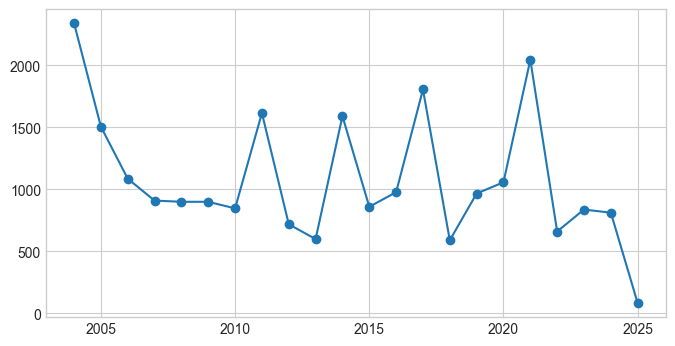

In [3]:
#nochmal drüber schauen!!

country_code = "DEU"

s = (df_country_mean.loc[df_country_mean["country"]==country_code, "value"]
     .dropna().sort_values())

# Tukey-Fences (robust, keine Verteilungsannahme)
q1, q3 = s.quantile([.25,.75]); iqr = q3 - q1
lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
mask_tukey = (s < lo) | (s > hi)

# Modifizierter Z-Score (Median & MAD, sehr robust bei Schiefe)
med = s.median()
mad = (s - med).abs().median()
M = 0.6745 * (s - med) / mad if mad != 0 else pd.Series(np.zeros(len(s)), index=s.index)
mask_modz = M.abs() > 3.5

print(f"[{country_code}] Tukey-Ausreißer: {mask_tukey.sum()}  |  ModZ-Ausreißer: {mask_modz.sum()}")

# Mini-Plot: Serie mit markierten Ausreißern
years = df_country_mean.loc[df_country_mean["country"]==country_code, "year"]
vals  = df_country_mean.loc[df_country_mean["country"]==country_code, "value"]
plt.figure(figsize=(8,4))
plt.plot(years, vals, marker="o", linewidth=1.5)
plt.scatter(years[mask_tukey.reindex_like(vals, fill_value=False)],
            vals[mask_tukey.reindex_like(vals, fill_value=False)],
            s=60, edgecolor="r", facecolor="none", label="Tukey")
plt.scatter(years[mask_modz.reindex_like(vals, fill_value=False)],
            vals[mask_modz.reindex_like(vals, fill_value=False)],
            s=60, edgecolor="orange", facecolor="none", label="ModZ")
plt.title(f"Zeitverlauf & Ausreißer – {country_code}")
plt.xlabel("Jahr"); plt.ylabel("Wert"); plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
# Histogramm (FD-Bins, Dichte) – robustes Default
x = s.to_numpy()
# FD-Binbreite
q1, q3 = np.percentile(x, [25,75]); iqr = q3-q1
bin_width = 2*iqr / (len(x)**(1/3)) if iqr>0 else None
bins = "fd" if bin_width is None else max(5, int(np.ceil((x.max()-x.min())/bin_width)))

plt.figure(figsize=(8,4))
plt.hist(x, bins=bins, density=True, edgecolor="black", alpha=0.35, label="Histogramm (Dichte)")

# KDE (optional): nutze seaborn ODER SciPy, falls installiert
try:
    import seaborn as sns
    sns.kdeplot(x=x, bw_adjust=1.0, label="KDE (bw_adjust=1.0)")
except Exception:
    try:
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(x)
        xx = np.linspace(x.min(), x.max(), 200)
        plt.plot(xx, kde(xx), label="KDE (gaussian_kde)")
    except Exception:
        pass  # kein KDE verfügbar – Histogramm reicht für den Bericht

plt.title(f"Histogramm + KDE – {country_code}")
plt.xlabel("Wert"); plt.ylabel("Dichte"); plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
# Daten für fokussierte Gruppen vorbereiten
df_focus = df_country_mean[df_country_mean["country"].isin(focus_countries)].copy()
# Reihenfolge: erst Top, dann Bottom in der y-Achse
order = top_countries + bottom_countries

# Boxplot je Land (robust – Median/IQR sichtbar)
plt.figure(figsize=(10,6))
data = [df_focus.loc[df_focus["country"]==c, "value"].dropna().values for c in order]
plt.boxplot(data, vert=False, labels=order, whis=1.5, showfliers=True)  # Tukey-Whisker
plt.title("Boxplot – Verteilungsübersicht ausgewählter Länder")
plt.xlabel("Wert"); plt.ylabel("Land"); plt.tight_layout(); plt.show()


In [ ]:
def ecdf(vals):
    v = np.sort(vals); n = len(v)
    y = np.arange(1, n+1)/n
    return v, y

plt.figure(figsize=(8,5))
for c in top_countries[:4]:  # z. B. die 4 Top-Länder
    v,_ = ecdf(df_country_mean.loc[df_country_mean["country"]==c, "value"].dropna().values)
    x,y = ecdf(v)
    plt.step(x, y, where="post", label=c)
plt.title("ECDF – Top-Länder (binfrei)")
plt.xlabel("Wert"); plt.ylabel("F(x)"); plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
vals = s.dropna().to_numpy()
try:
    import statsmodels.api as sm
    sm.qqplot(vals, line="45"); plt.title(f"Normal-QQ – {country_code}"); plt.tight_layout(); plt.show()
except Exception:
    try:
        from scipy import stats
        stats.probplot(vals, dist="norm", plot=plt); plt.title(f"Normal-QQ – {country_code}")
        plt.tight_layout(); plt.show()
    except Exception:
        print("QQ-Plot: statsmodels/scipy nicht verfügbar – Schritt im Bericht nur textlich beschreiben.")


In [ ]:
# Anteil fehlender Werte pro Land (in df, also vor Jahresmittel)
missing_rate = (df.groupby("country")["value"]
                .apply(lambda x: x.isna().mean())
                .rename("missing_rate"))

# zeitliche Streuung (Std der Jahresmittel) – „Zackigkeit“ im Verlauf
std_over_time = (df_country_mean.groupby("country")["value"]
                 .std().rename("std_over_time"))

dq = (pd.concat([avg_wellbeing.rename("mean_value"),
                 missing_rate, std_over_time], axis=1)
      .sort_values(["missing_rate","std_over_time"], ascending=[True, True]))

print(dq.head(10))   # beste Datenqualität
print(dq.tail(10))   # kritischste Datenqualität
